# Collisions Graph - mapping collisions to road networks

__Last update: June 2022__

This notebook provides an alternative to the method analysed in `clustering-collisions.ipynb`. Instead of clustering collisions together, we want to map collisions back to existing open source data on junctions.

I've found two sources we could use to map out junctions across London.

### Option 1 - https://github.com/AndGem/OsmToRoadGraph

I pulled the data for this source using:
`python run.py -f data/greater-london-latest.osm -n c --networkx`

You can modify the configuration.py file to remove certain road types etc. and I've used the car option (`c`) since it's mostly junctions which cars can use we're interested in.

### Option 2 - https://github.com/gboeing/osmnx

This second source is from the same raw data (AFAIK). This package allows us to read in the data directly into a graph object, which makes it easier to process. Plus there are some functions for simplifying the road network which might be useful.

__IDEAS / NOTES:__

- Clean up function works, but it deosn't do anything to leave in more major connections - how could we adapt it? One way would be to remove nodes with low degree.

__TODO:__ clean up imports - don't think all are needed?

In [1]:
import json
import os
import geopandas
import pandas as pd
import seaborn as sns
import osmnx as ox
import contextily as cx
import matplotlib.pyplot as plt

# this prevents a lot of future warnings that are coming out of oxmnx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy import spatial
from ipyleaflet import basemaps, Marker, Map
from dotenv import load_dotenv

load_dotenv()
os_api_key = os.getenv('OS_API_KEY')

%config InlineBackend.figure_format = 'retina'

sns.set_palette('Dark2')
plt.rcParams["font.family"] = "Calibri"
plt.rcParams["font.size"] = 12

In [2]:
def get_nearest_junction(row, tree):
    crash_coordinate = row[['latitude', 'longitude']].values
    result = tree.query(crash_coordinate)

    distance = result[0]
    junction_id = result[1]
    return distance, junction_id


# now done in pre-processing
# def weight_accident_severity(severity):
#     '''
#     Upweights more severe collisions for junction comparison.
#     '''
#     if severity == 'Fatal':
#         return 3
#     if severity == 'Serious':
#         return 1
#     else:
#         return 0

# 1. Read in collision data

`../data/london-crashes.csv` filter to serious and fatal collisions only.

In [3]:
# not a massive fan of the use of the term 'accidents'
collisions = pd.read_csv('../data/london-crashes.csv')

collisions.rename(columns={'accident_index': 'id'}, inplace=True)

collisions = collisions[
    (collisions['max_cyclist_severity'] != 'slight') &
    (collisions['junction_detail'] != 'Private drive or entrance')
]

# example rows
collisions.sample(5)

id  accident_year accident_reference  location_easting_osgr  \
340    200001DM02170           2000          01DM02170               528350.0   
42405  2018010097876           2018          010097876               529780.0   
36933  2016010021532           2016          010021532               528770.0   
48288  2020010250156           2020          010250156               536860.0   
3190   200101NI00718           2001          01NI00718               530250.0   

       location_northing_osgr  longitude   latitude         police_force  \
340                  179220.0  -0.152378  51.497304  Metropolitan Police   
42405                173810.0  -0.133768  51.448414  Metropolitan Police   
36933                181860.0  -0.145368  51.520934  Metropolitan Police   
48288                187491.0  -0.026640  51.569689  Metropolitan Police   
3190                 187020.0  -0.122139  51.566966  Metropolitan Police   

      accident_severity  number_of_vehicles  ...  \
340             Serious                   2  ...   
42405           Serious                   2  ...   
36933           Serious                   1  ...   
48288           Serious                   2  ...   
3190            Serious                   2  ...   

       did_police_officer_attend_scene_of_accident trunk_road_flag  \
340                                            Yes       Non-trunk   
42405                                          Yes       Non-trunk   
36933                                          Yes       Non-trunk   
48288                                          Yes       Non-trunk   
3190                                           Yes       Non-trunk   

      lsoa_of_accident_location              datetime  \
340                   E01004690  2000-10-18T22:40:00Z   
42405                 E01003162  2018-03-23T09:25:00Z   
36933                 E01004716  2016-09-15T08:05:00Z   
48288                 E01004427  2020-06-02T13:28:00Z   
3190                  E01002807  2001-06-04T22:50:00Z   

      fatal_cyclist_casualties serious_cyclist_casualties  \
340                          0                          1   
42405                        0                          1   
36933                        0                          1   
48288                        0                          1   
3190                         0                          1   

      slight_cyclist_casualties danger_metric recency_danger_metric  \
340                           0             1              0.301030   
42405                         0             1              1.301030   
36933                         0             1              1.255273   
48288                         0             1              1.342423   
3190                          0             1              0.477121   

      max_cyclist_severity  
340                serious  
42405              serious  
36933              serious  
48288              serious  
3190               serious  

[5 rows x 43 columns]

# 2. Load in option 1 junction graph

Stored in `../data/greater-london-latest.json`, which is from the output of this command: `python run.py -f data/greater-london-latest.osm -n c --networkx`

In [4]:
with open('../data/greater-london-latest.json') as f:
    d = json.load(f)

print(d.keys())

junctions_opt_1 = pd.DataFrame(d['nodes'])
junctions_opt_1.rename(
    columns={
        'lat': 'latitude',
        'lon': 'longitude',
        'id': 'junction_id'
    },
    inplace=True
)

del d

print(f'{len(junctions_opt_1)} junctions')
junctions_opt_1.sample(5)

dict_keys(['directed', 'multigraph', 'graph', 'nodes', 'adjacency'])
186846 junctions


latitude  longitude  junction_id
151980  51.433740  -0.067085       151980
145208  51.545540  -0.102925       145208
91076   51.363824  -0.098315        91076
51067   51.643131  -0.039380        51067
77668   51.522601  -0.447166        77668

# 3. Load in option 2 junction graph

Using `osmnx` package, which we can read in as a networkx graph object.

Simplify graph using the `consolidate_intersections` function.

See plot of simplified local example, before I pull full London network. It takes a while to process.

Nodes: 563


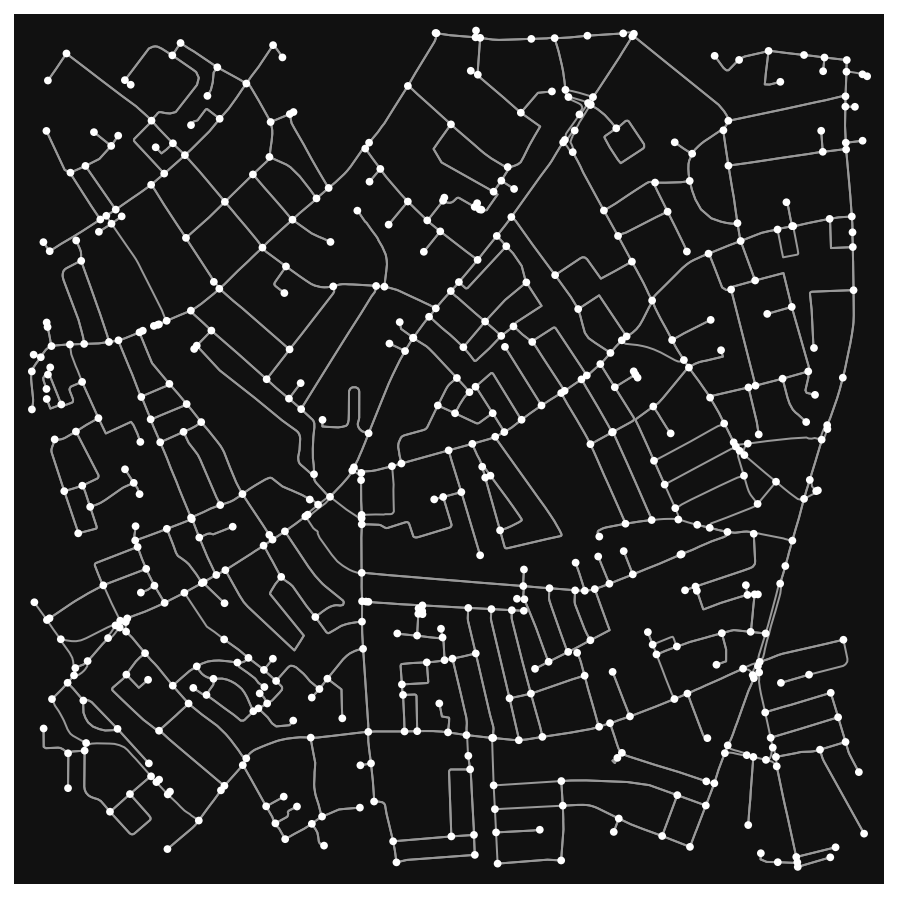

Nodes: 388


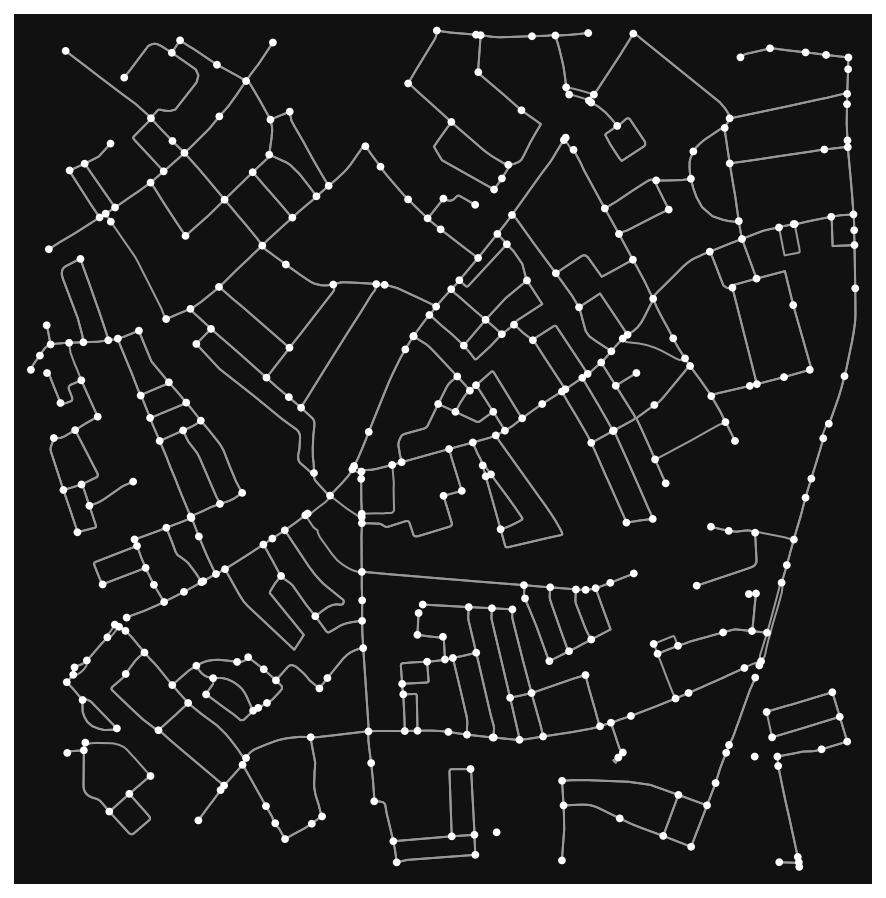

Nodes: 257


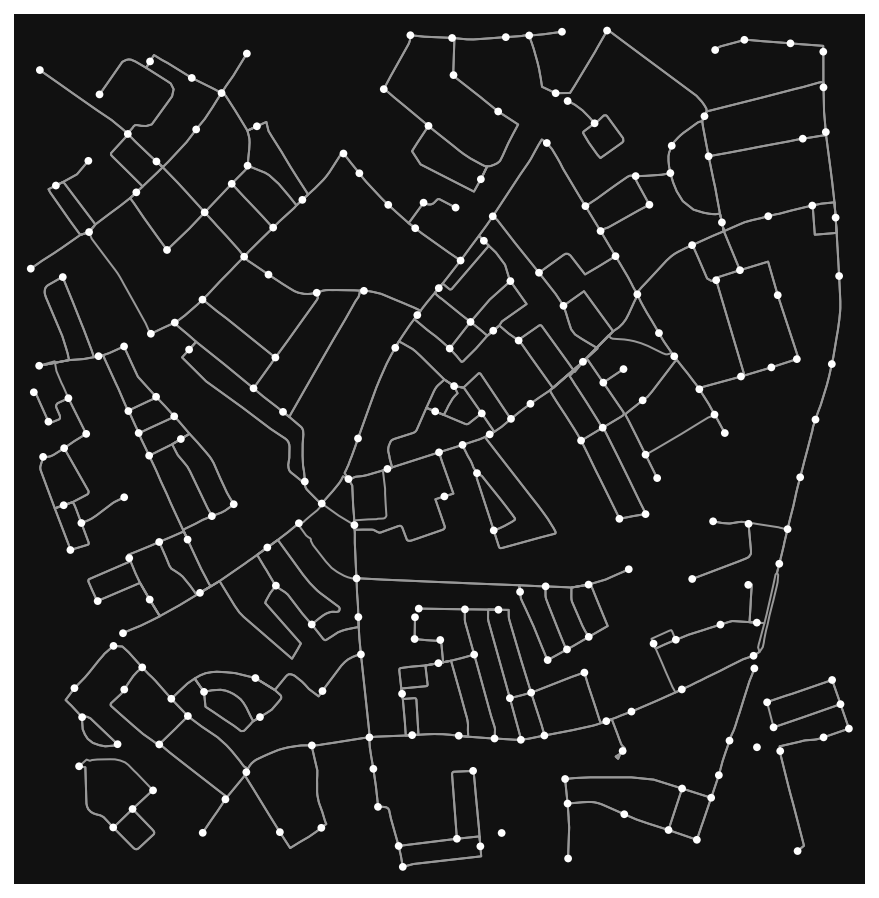

In [5]:
test_G = ox.graph_from_address('Landor Road, London, UK', network_type='drive')

print(f'Nodes: {len(test_G.nodes)}')
ox.plot_graph(test_G)

# Remove nodes with low degree

nodes_to_remove = [node for node,degree in dict(test_G.degree()).items() if degree <= 3]
test_G.remove_nodes_from(nodes_to_remove)

print(f'Nodes: {len(test_G.nodes)}')
ox.plot_graph(test_G);

test_G = ox.consolidate_intersections(
    ox.project_graph(test_G),
    tolerance=25,  # combines junctions within 25m
    rebuild_graph=True,
    dead_ends=False
)

print(f'Nodes: {len(test_G.nodes)}')
ox.plot_graph(test_G);

In [6]:
G = ox.graph_from_address(
    'London, UK',
    dist=15000,
    network_type='drive'
)
print(f'Nodes: {len(G.nodes)}')

# Remove nodes with low degree

nodes_to_remove = [node for node,degree in dict(G.degree()).items() if degree <= 2]
G.remove_nodes_from(nodes_to_remove)
print(f'Nodes: {len(G.nodes)}')

G = ox.consolidate_intersections(
    ox.project_graph(G),
    tolerance=35,
    rebuild_graph=True,
    dead_ends=False
)
print(f'Nodes: {len(G.nodes)}')

ids, lats, lons = [], [], []

n = 0
for node in G.nodes(data=True):
    try:
        lons.append(node[1]['lon'])
        lats.append(node[1]['lat'])
        ids.append(n)
        n += 1
    except:
        continue

junctions_opt_2 = pd.DataFrame({
    'latitude': lats,
    'longitude': lons,
    'junction_id': ids
})

junctions_opt_2

Nodes: 88208
Nodes: 67154
Nodes: 24923


latitude  longitude  junction_id
0      51.535179  -0.148104            0
1      51.528960  -0.145843            1
2      51.537514  -0.152655            2
3      51.537330  -0.154627            3
4      51.534054  -0.162657            4
...          ...        ...          ...
13940  51.499592   0.031538        13940
13941  51.560109  -0.280631        13941
13942  51.375017  -0.278856        13942
13943  51.395847  -0.020291        13943
13944  51.586787  -0.004523        13944

[13945 rows x 3 columns]

## 3.1 Plot junctions map

See if simplification at right level...

`tolerance=50` was definitely too high, `tolerance=25` seems like okay compromise. Also dependent on the initial `dist` parameter, since that sets the initital number of nodes.

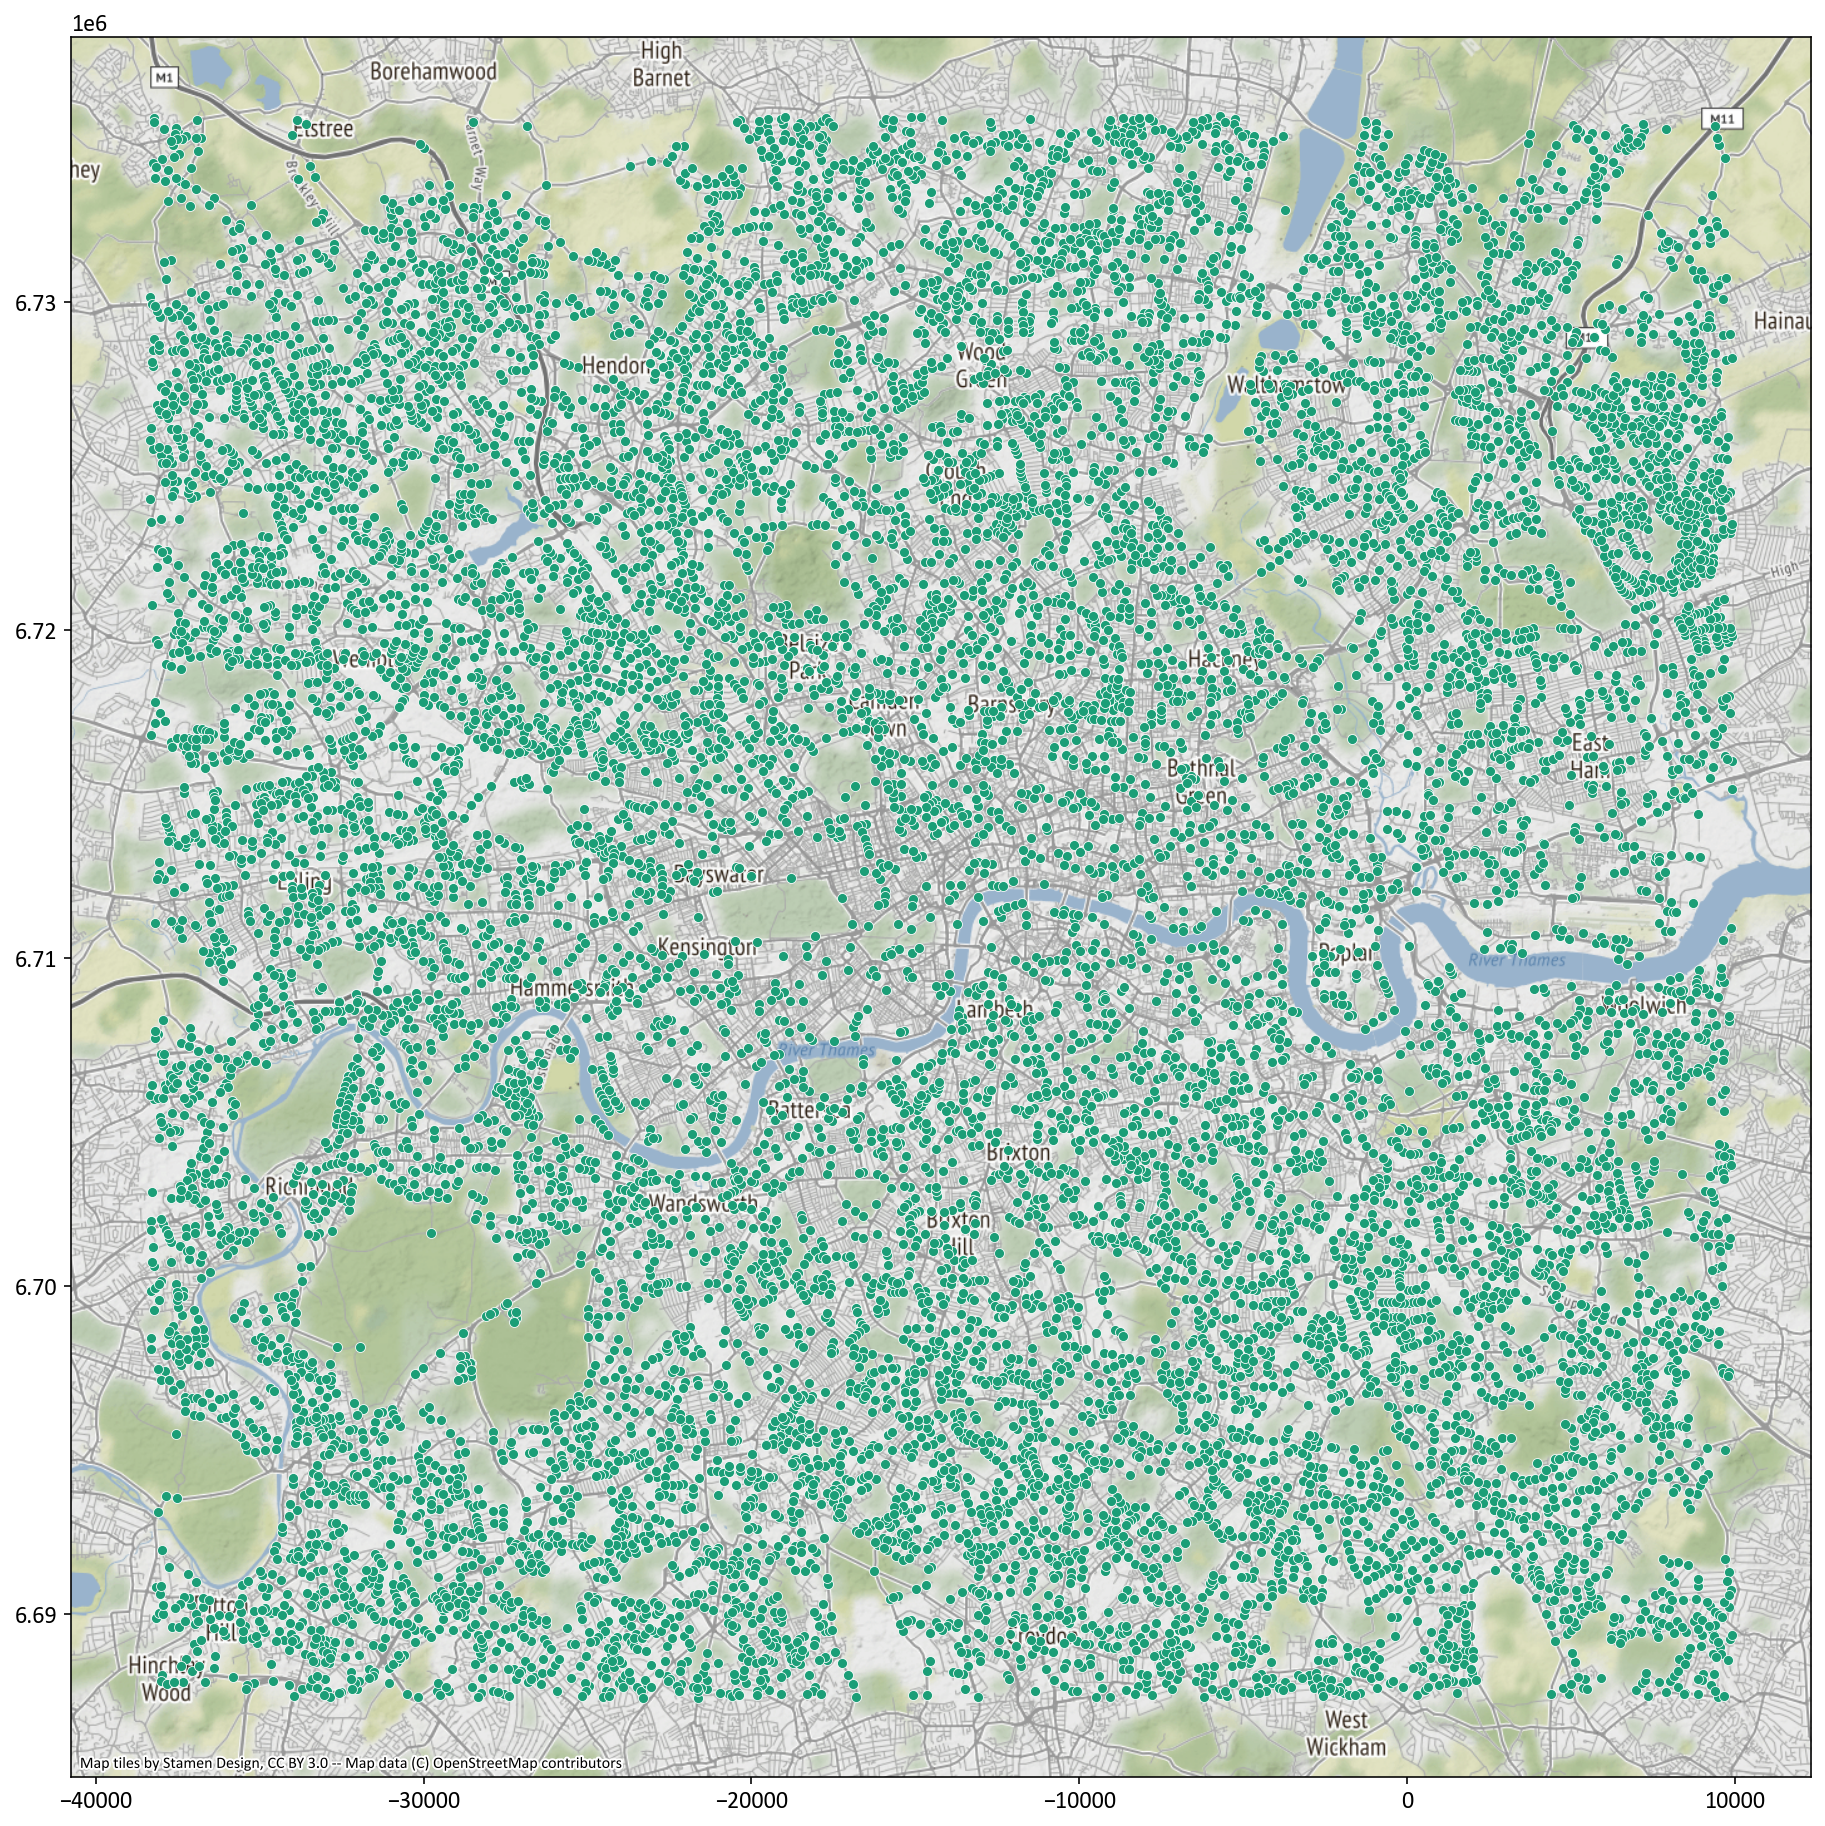

In [7]:
gpd_junctions_opt_2 = geopandas.GeoDataFrame(
    junctions_opt_2,
    geometry=geopandas.points_from_xy(junctions_opt_2.longitude, junctions_opt_2.latitude, crs="EPSG:4326")
)

gpd_junctions_opt_2.to_crs(epsg=3857, inplace=True)

fig, ax = plt.subplots(figsize=(24, 16))

sns.scatterplot(
    x=gpd_junctions_opt_2.geometry.x,
    y=gpd_junctions_opt_2.geometry.y,
    alpha=1,
    s=25
);

cx.add_basemap(ax)

# 4. Assign collisions to junctions

Now we have two junction graphs we want to assign collisions to a junction based on the closest one.

https://en.wikipedia.org/wiki/K-d_tree

In [8]:
# create k-d trees..
tree_opt_1 = spatial.KDTree(junctions_opt_1[['latitude', 'longitude']])
tree_opt_2 = spatial.KDTree(junctions_opt_2[['latitude', 'longitude']])

collisions[['distance_opt_1', 'junction_id_opt_1']] = collisions.apply(
    lambda row: get_nearest_junction(row, tree_opt_1), axis=1, result_type='expand'
)
collisions[['distance_opt_2', 'junction_id_opt_2']] = collisions.apply(
    lambda row: get_nearest_junction(row, tree_opt_2), axis=1, result_type='expand'
)

collisions.sample(5)

id  accident_year accident_reference  location_easting_osgr  \
9227   200501CP00158           2005          01CP00158               532730.0   
37267  201601BS70311           2016          01BS70311               524950.0   
6370   200301GD00773           2003          01GD00773               536240.0   
40101  2017010038712           2017          010038712               527470.0   
35178  201501LX50584           2015          01LX50584               531210.0   

       location_northing_osgr  longitude   latitude         police_force  \
9227                 181130.0  -0.088598  51.513457       City of London   
37267                179240.0  -0.201326  51.498245  Metropolitan Police   
6370                 184860.0  -0.036604  51.546142  Metropolitan Police   
40101                175020.0  -0.166557  51.459813  Metropolitan Police   
35178                173840.0  -0.113216  51.448354  Metropolitan Police   

      accident_severity  number_of_vehicles  ...  fatal_cyclist_casualties  \
9227            Serious                   2  ...                         0   
37267           Serious                   1  ...                         0   
6370            Serious                   2  ...                         0   
40101           Serious                   2  ...                         0   
35178           Serious                   2  ...                         0   

      serious_cyclist_casualties slight_cyclist_casualties danger_metric  \
9227                           1                         0             1   
37267                          1                         0             1   
6370                           1                         0             1   
40101                          1                         0             1   
35178                          1                         0             1   

      recency_danger_metric max_cyclist_severity distance_opt_1  \
9227               0.845098              serious       0.000081   
37267              1.255273              serious       0.000176   
6370               0.698970              serious       0.000166   
40101              1.278754              serious       0.000038   
35178              1.230449              serious       0.000117   

      junction_id_opt_1 distance_opt_2 junction_id_opt_2  
9227            93683.0       0.001391            2639.0  
37267            4775.0       0.001252            5628.0  
6370             4464.0       0.001032            1191.0  
40101            8572.0       0.002718            5263.0  
35178           31014.0       0.001322           13409.0  

[5 rows x 47 columns]

# 5. Join data to nearest junction and summarise

Do we need a maximum distance filter?

Maximum distance filter needed for opt 2 as the network doesn't extend out far enough relative to the collision data yet.

In [9]:
n = 80

junctions_stats_opt_1 = (
    collisions
    .merge(junctions_opt_1, how='left', left_on='junction_id_opt_1', right_on='junction_id')
    .groupby(['junction_id', 'latitude_y', 'longitude_y'])['cyclist_casualty_weight']
    .sum()
    .reset_index()
    .rename(columns={'latitude_y': 'latitude_junction', 'longitude_y': 'longitude_junction'})
    .sort_values(by='cyclist_casualty_weight', ascending=False)
    .head(n)
)

display(junctions_stats_opt_1.head(10))

gpd_junctions_stats_opt_1 = geopandas.GeoDataFrame(
    junctions_stats_opt_1,
    geometry=geopandas.points_from_xy(
        junctions_stats_opt_1.longitude_junction,
        junctions_stats_opt_1.latitude_junction,
        crs="EPSG:4326"
    )
)

gpd_junctions_stats_opt_1.to_crs(epsg=3857, inplace=True)

fig, ax = plt.subplots(figsize=(24, 16))

sns.scatterplot(
    x=gpd_junctions_stats_opt_1.geometry.x,
    y=gpd_junctions_stats_opt_1.geometry.y,
    alpha=1,
    s=100
);

cx.add_basemap(ax)

del gpd_junctions_stats_opt_1

KeyError: 'Column not found: cyclist_casualty_weight'

## 5.1 Plot distances distribution for option 2

To help decide cut off value, set to `< .002`

In [ ]:
sns.displot(
    collisions.distance_opt_2,
    height=6,
    aspect=1.6
)
plt.xlabel('Distance to nearest junction');

In [ ]:
n = 80

junctions_stats_opt_2 = (
    collisions
    [collisions.distance_opt_2 < .002]
    .merge(junctions_opt_2, how='left', left_on='junction_id_opt_2', right_on='junction_id')
    .groupby(['junction_id', 'latitude_y', 'longitude_y'])['cyclist_casualty_weight']
    .sum()
    .reset_index()
    .rename(columns={'latitude_y': 'latitude_junction', 'longitude_y': 'longitude_junction'})
    .sort_values(by='cyclist_casualty_weight', ascending=False)
    .head(n)
)

display(junctions_stats_opt_2.head(10))

gpd_junctions_stats_opt_2 = geopandas.GeoDataFrame(
    junctions_stats_opt_2,
    geometry=geopandas.points_from_xy(
        junctions_stats_opt_2.longitude_junction,
        junctions_stats_opt_2.latitude_junction,
        crs="EPSG:4326"
    )
)

gpd_junctions_stats_opt_2.to_crs(epsg=3857, inplace=True)

fig, ax = plt.subplots(figsize=(24, 16))

sns.scatterplot(
    x=gpd_junctions_stats_opt_2.geometry.x,
    y=gpd_junctions_stats_opt_2.geometry.y,
    alpha=1,
    s=100
);

cx.add_basemap(ax)

del gpd_junctions_stats_opt_2

# Traffic volume data

Not quite sure how to combine this in yet.

In [ ]:
raw_volumes = pd.read_csv('../data/dft_aadfbydirection_region_id_6.csv')

# filter to London area
# 51.455953, 51.541914
# -.198716, -.077560

raw_volumes = raw_volumes[
    (raw_volumes['longitude'] >= -.198716) &
    (raw_volumes['longitude'] <= -.077560) &
    (raw_volumes['latitude'] >= 51.455953) &
    (raw_volumes['latitude'] <= 51.541914)
]

volumes = (
    raw_volumes
    .groupby([
        'latitude',
        'longitude'
#         , 'direction_of_travel'
    ])['all_motor_vehicles']
    .sum()
    .reset_index()
)

del raw_volumes

gpd_volumes = geopandas.GeoDataFrame(
    volumes,
    geometry=geopandas.points_from_xy(
        volumes.longitude,
        volumes.latitude,
        crs="EPSG:4326"
    )
)

gpd_volumes.to_crs(epsg=3857, inplace=True)

fig, ax = plt.subplots(figsize=(24, 16))

sns.scatterplot(
    x=gpd_volumes.geometry.x,
    y=gpd_volumes.geometry.y,
    hue=gpd_volumes.all_motor_vehicles,
    alpha=1,
    s=100
);

cx.add_basemap(ax)

del gpd_volumes

volumes.sample(5)